# Open Street Map Project - Analysis of Whittier, CA OSM Data

## By Jacob Dodd

### Background

For my Data Analyst Nanodegree (https://www.udacity.com/course/data-analyst-nanodegree--nd002), I was tasked with extracting data from Open Street Map (https://www.openstreetmap.org/), and auditing, cleaning, and loading it into a SQLite database for analysis. 

I was able to accomplish this via Python scripts that ran through the extracted xml files and then audited and cleaned them into csv files. The csvs were then loaded into a sqlite database, where I ran queries analyzing the data.

Additional analysis using the pandas, matplotlib, seaborn, and numpy libraries as well. 

## Map Area: Whittier, CA
My hometown!


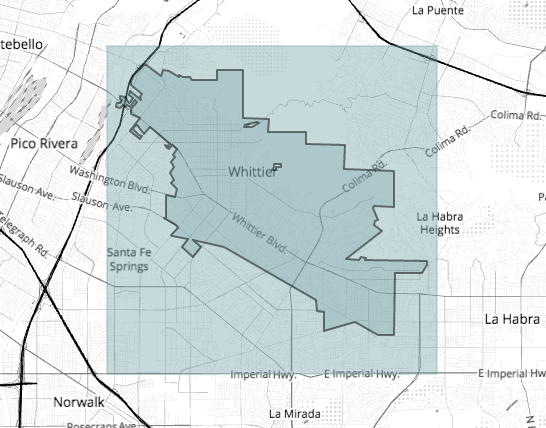

In [9]:
from IPython.display import Image
Image("whittiermap.png")

Above is the custom extract from the Mapzen API. 
Whittier is an LA area suburb of ~85K people, teetering on the border of LA and Orange Counties. I am interested in seeing what the data reveals, and hopefully clean up some problems in the dataset. 

The reason for for the bounding I chose was that I wanted to include the area to the lower left of the box, "South Whittier", an un-incorporated area (LA County) that most Whittier-ites would count as Whittier. 
- https://en.wikipedia.org/wiki/Whittier,_California

### Project Format
- Problems Encountered
- File Overview and Stats
- Suggestions and Discussion
- Additional Analysis of Contributions in Python
- Conclusion

## Problems Encountered

<b> Road Auditing

In [ ]:
"""
{'A': set(['Carmenita Rd #A', 'Hadley Street Suite A']),
 'Blvd': set(['South Hacienda Blvd', 'Whittier Blvd']),
 'Rd': set(['Telegraph Rd'])}
Whittier Blvd => Whittier Boulevard
South Hacienda Blvd => South Hacienda Boulevard
Carmenita Rd #A => Carmenita Road 
Hadley Street Suite A => Hadley Street  
Telegraph Rd => Telegraph Road
"""

Most of the Road Data was surprisingly clean. There were some exceptions:
- Road names ending with address ("Suite A")
- Blvd and Rd abbreviations

These were both easy fixes, with some updating of my update name function and my mapping dictionary. 

<b> Descrepencies with Zip Codes and Street Names

In [ ]:
	<way changeset="13017994" id="13335265" timestamp="2012-09-07T02:30:42Z" uid="358440" user="russdeffner" version="6">
		<nd ref="122770749" />
		<nd ref="1903424070" />
		<nd ref="1903424092" />
		<nd ref="1903424185" />
		<nd ref="1903424179" />
		<nd ref="1903424064" />
		<nd ref="1903424052" />
		<nd ref="1903424047" />
		<nd ref="1903424038" />
		<nd ref="1903424159" />
		<nd ref="1903424113" />
		<nd ref="1903424149" />
		<nd ref="1903424147" />
		<nd ref="1903424161" />
		<nd ref="1903424170" />
		<nd ref="1903424130" />
		<nd ref="1903424134" />
		<nd ref="1903424044" />
		<tag k="name" v="Pine Bluff Drive" />
		<tag k="highway" v="residential" />
		<tag k="tiger:cfcc" v="A41" />
		<tag k="tiger:tlid" v="141775327" />
		<tag k="tiger:county" v="Los Angeles, CA" />
		<tag k="tiger:source" v="tiger_import_dch_v0.6_20070809" />
		<tag k="tiger:zip_left" v="90601" />
		<tag k="tiger:name_base" v="Pine Bluff" />
		<tag k="tiger:name_type" v="Dr" />
		<tag k="tiger:separated" v="no" />
		<tag k="tiger:zip_right" v="90601" />
	</way>

1) Street Names

 Names imported from Tiger GPS had street names divided between 'name_base' and 'name_type'.
 

2) Zips

 Some of the ways files, like the example above, had both a "zip_left" and "zip_right" tag, so determining the zip code could be difficult. I queried both and compared the results.


Knowing that the elements that contained one contained the other one of these tags, I am simply looking for unusual zip codes.

In [ ]:
sqlite> SELECT tags.value, COUNT(*) as sum
   ...> FROM (SELECT * FROM nodes_tags
   ...> UNION ALL
   ...> SELECT * FROM ways_tags) tags
   ...> WHERE tags.key='zip_left'
   ...> GROUP BY tags.value
   ...> ORDER BY sum DESC;

sqlite> SELECT tags.value, COUNT(*) as sum
   ...> FROM (SELECT * FROM nodes_tags
   ...> UNION ALL
   ...> SELECT * FROM ways_tags) tags
   ...> WHERE tags.key='zip_right'
   ...> GROUP BY tags.value
   ...> ORDER BY sum DESC;

In [ ]:
ZIP LEFT

90604|573
90603|506
91745|408
90606|337
90605|336
90601|322
90631|235
90638|187
90602|159
90670|128
90660|49
90602:90605|47
90650|33
90608|3

ZIP RIGHT

90604|593
90603|501
91745|401
90605|334
90601|321
90606|317
90631|233
90602|179
90638|159
90670|112
90660|50
90602:90605|47
90650|33
91744|3
90608|1

For the most part, these are accurate!
- 90604, 90603 are Whittier, while 91745 is Hacienda Heights (east of Whittier)


However:

- 90608 does not exist. There are only three tag values with this zip,however, and they can be corrected to 90601.
- 90602:90605 as a value is incorrect. A possiblity is that the user was unsure of which zip to go with so they gave a range. This can be corrected with either 90602 or 90605.
- to address this, I created a function called "update_zip" that audits for this string and 
    

## File Overview and Statistics

### File Sizes

- whittier.osm ....... 210.4 MB
- whittier_osm.db ....... 118.8 MB
- nodes.csv ...... 86.4 MB
- ways_nodes.csv ...... 24.5 MB
- ways_tags.csv ...... 19.5
- ways.csv ...... 6.2 MB
- nodes_tags.csv ...... 128 KB

### Unique Users

In [ ]:
sqlite> SELECT COUNT(DISTINCT(users.uid))
   ...> FROM (SELECT uid FROM nodes UNION ALL 
   ...> SELECT uid FROM ways) users;

In [ ]:
209

There are 209 unique users that contributed to the nodes or ways elements in this file.

### Number of Nodes

In [ ]:
sqlite> SELECT COUNT(*) FROM nodes;

In [ ]:
914475

### Number of Ways

In [ ]:
sqlite> SELECT COUNT(*) FROM ways;

In [ ]:
89337

### Top Node Keys

In [ ]:
sqlite> SELECT key, COUNT(key) as count
   ...> FROM nodes_tags
   ...> GROUP BY key
   ...> ORDER BY count DESC
   ...> LIMIT 20;

In [ ]:
highway|912
power|504
name|223
amenity|165
ele|157
feature_id|145
county_id|136
created|136
state_id|136
odbl|79
source|62
religion|58
natural|48
edited|40
railway|38
type|37
structure|35
design|34
material|34
housenumber|26

### Top Ways Keys 

In [ ]:
sqlite> SELECT key, COUNT(key) as count
   ...> FROM ways_tags
   ...> GROUP BY key
   ...> ORDER BY count DESC
   ...> LIMIT 20;

In [ ]:
building,80816
ele,77109
bld_id,77080
height,77080
ain,77079
start_date,75092
units,71678
highway,6831
name,4805
county,3472
cfcc,3444
name_base,3415
name_type,3357
zip_left,3323
zip_right,3284
source,2218
lanes,2079
tlid,1526
separated,1521
oneway,1335

### Top 15 Users who Contributed

In [ ]:
sqlite> SELECT users.user, COUNT(*) as total
   ...> FROM (SELECT user FROM nodes UNION ALL 
   ...> SELECT user FROM ways) users
   ...> GROUP BY users.user
   ...> ORDER BY total DESC
   ...> LIMIT 15;

In [ ]:
calfarome_labuilding|210673
yurasi_import|173569
piligab_labuildings|129035
RichRico_labuildings|121388
ridixcr_import|91900
manoharuss_imports|71383
Jothirnadh_labuildings|68547
dannykath_labuildings|44361
karitotp_labuildings|36681
Luis36995_labuildings|10214
Rockear|4535
Brian@Brea|3653
manings_labuildings|3485
Christine_E|2611
RichRico|2510

The "_labuildings" at the end of some these top users makes me wonder if there was a "LA Buildings" mapathon or maybe some GIS interns at LA County were tasked with doing this, which would explain why many of these are in the top 10. We can look at the date contributed to verify this.

### Top Amenities

In [ ]:
sqlite> SELECT tags.value, COUNT(*) as sum
   ...> FROM (SELECT * FROM nodes_tags
   ...> UNION ALL
   ...> SELECT * FROM ways_tags) tags
   ...> WHERE tags.key='amenity'
   ...> GROUP BY tags.value
   ...> ORDER BY sum DESC;

In [ ]:
parking|147
school|84
place_of_worship|74
grave_yard|33
fast_food|16
fuel|13
toilets|9
restaurant|7
fire_station|6
clinic|5
library|5
social_facility|5
hospital|4
community_centre|3
fountain|3
bank|2
pharmacy|2
post_office|2
theatre|2
atm|1
bus_station|1
college|1
courthouse|1
doctors|1
drinking_water|1
post_box|1
townhall|1

33 Nodes with an Amenity value of Graveyard? No doubt these must be referring to Rose Hills, a large Memorial Park in the hills North of Whittier. 74 Places of Worship sound accurate as well. In the nodes keys, some values were religious. Let's take a closer look there.

### Most Popular Religions

I would expect some sort of Christianity to be at the top here. There is a large amount of Christian and Catholic churches in the area.

In [ ]:
sqlite> SELECT value, COUNT(*) as sum
   ...> FROM nodes_tags
   ...> WHERE key = 'religion'
   ...> GROUP BY value
   ...> ;

In [ ]:
christian|57
jewish|1

Not much here. As predicted, christianity is the most popular religion, though I wonder if Catholic is lumped in with that. 

### State Id

This was another large node_tag key value. I would predict all will be one value.

In [ ]:
sqlite> SELECT value, COUNT(*) as sum
   ...> FROM nodes_tags
   ...> WHERE key = 'state_id'
   ...> GROUP BY value
   ...> ;

In [ ]:
06|136

Good! The state id value is the same for each node with state_id. There is only one state in the Map area (CA).

## Suggestions and Discussion

### Most of the Data added by "_labuildings" and "_imports" Users

The led to many of the nodes being for buildings, with building IDs, elevation (presumeably as part of work for the County or City of Whittier) and other administrative information. This data also mosly came imported from Tiger GPS devices. 

As a result, the amenities values were lacking, with many not being resteraunts, or other features of the urban landscape. 

The lack of diversity in the users uploading information led to a lack of diversity in the nodes and ways elements.

There needs to be a larger diversity of users who add information for their to be more descriptive info.

### Possible Improvements

One potential trove of data is Pokestop data from the PokemonGO mobile video game. This game uses your geographic location as a map, and there are "Pokestops", which represent real-life points of interest where you can get items. Think of Pokestops as nodes!

Benefits:

1) The pokestop data is probably in a similar format as nodes/tags data. There are lat/long, timestamp, id, which are the main components that could be easily appended

2) Add diversity of nodes tags- the fact that pokestops are anything from interesting buildings to murals to businesses will add a great deal of diversity in the key values. This will give a more complete picture of the city, at least from a cultural or local perspective.

Drawbacks:

1) Might be hard to obtain data, depending on the quality of APIs, and legality.

2) Effort in writing script making API calls might not be worth the amount of effort required- the number of pokestops most likely will not add more than 200 rows to the nodes file.

I will end with analysis of the "highway" key values:
### Highway Key Values

In [ ]:
sqlite> SELECT value, COUNT(*) as sum
   ...> FROM nodes_tags
   ...> WHERE key='highway'
   ...> GROUP BY value;

In [ ]:
bus_stop|26
crossing|24
motorway_junction|7
stop|7
traffic_signals|40
turning_circle|807
turning_loop|1

## Analysis using Python

In [1]:
import pandas as pd
import numpy as np

In [5]:
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as dates
%matplotlib inline

To get a good idea of the user data and contributions over time, I will look at the nodes and ways csv files that were wrangled above, loaded into pandas dataframes.

In [220]:
nodes = pd.read_csv("nodes.csv",parse_dates=['timestamp'])
ways = pd.read_csv("ways.csv",parse_dates=['timestamp'])
nodes_tags = pd.read_csv("nodes_tags.csv")
ways_tags = pd.read_csv("ways_tags.csv")

In [3]:
nodes.head()

,id,lat,lon,user,uid,version,changeset,timestamp
0,668163,34.008857,-118.058493,jerjozwik,36489,15,786030,2009-03-11 05:05:27
1,668164,34.007498,-118.060141,jerjozwik,36489,15,786030,2009-03-11 05:05:27
2,668165,34.002680,-118.065926,Sundance,239998,17,5070451,2010-06-25 00:11:24
3,668166,34.001222,-118.067053,Sundance,239998,18,5070451,2010-06-25 00:11:24
4,668167,33.999830,-118.067737,Sundance,239998,16,5070451,2010-06-25 00:11:24


In [223]:
ways_tags.head()

,id,key,value,type
0,13254889,name,Las Lomitas Drive,regular
1,13254889,highway,tertiary,regular
2,13254889,cfcc,A41,tiger
3,13254889,county,"Los Angeles, CA",tiger
4,13254889,reviewed,no,tiger


In [4]:
nodes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 914475 entries, 0 to 914474
Data columns (total 8 columns):
id           914475 non-null int64
lat          914475 non-null float64
lon          914475 non-null float64
user         914475 non-null object
uid          914475 non-null int64
version      914475 non-null int64
changeset    914475 non-null int64
timestamp    914475 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(4), object(1)
memory usage: 55.8+ MB


In [152]:
ways.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89337 entries, 0 to 89336
Data columns (total 7 columns):
id           89337 non-null int64
user         89337 non-null object
uid          89337 non-null int64
version      89337 non-null int64
changeset    89337 non-null int64
timestamp    89337 non-null datetime64[ns]
is_lab       89337 non-null int64
dtypes: datetime64[ns](1), int64(5), object(1)
memory usage: 4.8+ MB


The Nodes file contains information on OSM nodes, and the ways the OSM ways. What I am interested in doing here is getting the data into a time series format, then plot contributions over time.

To do this, I will group each data frame by their timestamp to count the contributions by timestamp. This will result in both data frames being a format that will making joining them easy.

### Time Series Analysis

In [115]:
#getting the grouped contribution counts (by timestamp) and then resetting the index
time_series = pd.DataFrame(nodes['timestamp'].value_counts().reset_index())
time_series_ways = pd.DataFrame(ways['timestamp'].value_counts().reset_index())

#setting column names
time_series.columns = ['date', 'count']
time_series_ways.columns = ['date', 'count']

#joining the ways and nodes dataframes
time_series = time_series.append(time_series_ways)

#setting the index as the data
time_series.set_index(time_series["date"],inplace=True)

#summing the counts by week/Day
#time_series = time_series.resample("D").sum()
#time_series['date'] = time_series.index

#filling in the null values with 0
time_series['count'].fillna(0,inplace=True)

time_series

,date,count
date,,
2017-02-02 20:31:57,2017-02-02 20:31:57,178
2017-02-02 20:32:01,2017-02-02 20:32:01,174
2017-02-02 20:31:56,2017-02-02 20:31:56,173
2017-02-02 20:32:00,2017-02-02 20:32:00,173
2017-02-02 20:31:59,2017-02-02 20:31:59,172
2017-02-02 20:31:58,2017-02-02 20:31:58,171
2017-02-02 20:32:02,2017-02-02 20:32:02,169
2017-02-02 20:32:06,2017-02-02 20:32:06,169
2017-02-02 20:32:07,2017-02-02 20:32:07,169


In [121]:
#verifying the counts equal the amount of rows of the dataset
time_series['count'].sum() == (nodes.shape[0] + ways.shape[0])

True

In [122]:
#Looking at new table
time_series.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 34403 entries, 2017-02-02 20:31:57 to 2015-07-09 15:17:20
Data columns (total 2 columns):
date     34403 non-null datetime64[ns]
count    34403 non-null int64
dtypes: datetime64[ns](1), int64(1)
memory usage: 806.3 KB


There are 34403 different timestamps. Let's take a look at the date range.

In [123]:
print("max:",time_series.index.min(), "min:",time_series.index.max())


('max:', Timestamp('2007-11-18 21:16:53'), 'min:', Timestamp('2017-10-21 10:44:06'))


The dataset has contributions from November 2007 to October 2017, when I started this project.

In [124]:
#Analyzing distributions
time_series.describe()

,count
count,34403.000000
mean,29.178037
std,31.625567
min,1.000000
25%,5.000000
50%,8.000000
75%,63.000000
max,178.000000


The new dataset has 34403 rows, with a mean of 29 contributions, and a max of 178 contributions.

### Time Series EDA

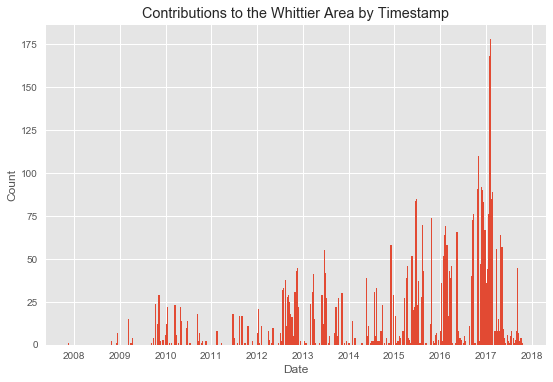

In [217]:
time_series.sort_index(inplace=True)
#time_series
ax = plt.subplot(111)
ax.bar(time_series.index, time_series['count'],width=10)
plt.ylabel("Count")
plt.xlabel("Date")
plt.title("Contributions to the Whittier Area by Timestamp")
ax.xaxis_date()

We see that contributions to the Whittier area increased over time, with a large spike in 2017. The max number of contributions occured in this area as well. 

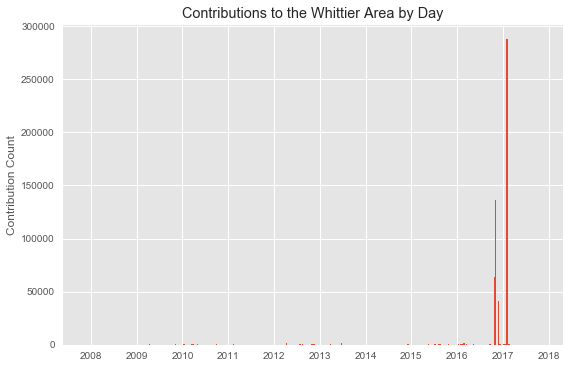

In [216]:
time_series = time_series.sort_values('date', ascending=True)

#summing the counts by week/Day
time_week = time_series.resample("D").sum()

#plt.figure(figsize=(12,6))
plt.style.use("ggplot")
#plt.bar(bottom=time_week.index, height=time_week['count'],data=time_week)
#plt.xticks(rotation=45)
plt.ylabel("Contribution Count")
plt.title("Contributions to the Whittier Area by Day")

ax = plt.subplot(111)
#ax.bar(x, y, width=10)
ax.bar(time_week.index,time_week['count'],width=10)
ax.xaxis_date()

The most of the contributions came from what looks like 2 days, one in late 2016 and the other in early 2017. I think that the la_buildings users could be involved here. Let's see.
    

In [128]:
nodes[(nodes['timestamp'].dt.year == 2017) |
      (nodes['timestamp'].dt.year == 2016)]['user'].value_counts().head(10)

calfarome_labuilding      193629
yurasi_import             159068
piligab_labuildings       117942
RichRico_labuildings      109861
ridixcr_import             83508
manoharuss_imports         65250
Jothirnadh_labuildings     63802
dannykath_labuildings      40427
karitotp_labuildings       33333
Luis36995_labuildings       9431
Name: user, dtype: int64

In [129]:
ways[(ways['timestamp'].dt.year == 2017) |
      (ways['timestamp'].dt.year == 2016)]['user'].value_counts().head(10)

calfarome_labuilding      17044
yurasi_import             14501
RichRico_labuildings      11527
piligab_labuildings       11093
ridixcr_import             8392
manoharuss_imports         6133
Jothirnadh_labuildings     4745
dannykath_labuildings      3934
karitotp_labuildings       3348
RichRico                    816
Name: user, dtype: int64

Sure enough, the top users here are la_buiildings and _imports users. 

Let's now create a function that flags these users, then plot them compared to all contributions across time. 

### Analyzing contributions from _labuilding and _imports users

In [110]:
import re

def islab(string):
    if re.search(pattern="_labuilding", string=str(string)):
        return 1
    elif re.search(pattern="_imports", string=str(string)):
        return 1
    else:
        return 0

Testing the new function:

In [111]:
islab("john_labuilding")

1

In [130]:
#applying function across nodes dataframe
nodes['is_lab'] = nodes['user'].apply(lambda x: islab(x))
ways['is_lab'] = ways['user'].apply(lambda x: islab(x))

#creating dataframes
lab = nodes[nodes['is_lab']==1]
lab2 = ways[ways['is_lab']==1]

In [131]:
lab.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 636798 entries, 10391 to 913244
Data columns (total 9 columns):
id           636798 non-null int64
lat          636798 non-null float64
lon          636798 non-null float64
user         636798 non-null object
uid          636798 non-null int64
version      636798 non-null int64
changeset    636798 non-null int64
timestamp    636798 non-null datetime64[ns]
is_lab       636798 non-null int64
dtypes: datetime64[ns](1), float64(2), int64(5), object(1)
memory usage: 48.6+ MB


In [132]:
lab2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58988 entries, 2253 to 89006
Data columns (total 7 columns):
id           58988 non-null int64
user         58988 non-null object
uid          58988 non-null int64
version      58988 non-null int64
changeset    58988 non-null int64
timestamp    58988 non-null datetime64[ns]
is_lab       58988 non-null int64
dtypes: datetime64[ns](1), int64(5), object(1)
memory usage: 3.6+ MB


## Labuildings and imports User Conclusion

In [148]:
print "Contributions by _labuildings and _imports users"
print("Nodes Contributions:",sum(nodes['is_lab']))
print("Ways Contributions:",sum(ways['is_lab']))

totalContib = (nodes.shape[0] + ways.shape[0])
totalLaContib = (sum(nodes['is_lab']) +sum(ways['is_lab']))
print("Total Contib by above users:",totalLaContib)

print "\n"
print "Total Contributions:", totalContib
print "Proportion of contribtions by _labuilding and _imports users:"
print(float(totalLaContib)/totalContib)

Contributions by _labuildings and _imports users
('Nodes Contributions:', 636798)
('Ways Contributions:', 58988)
('Total Contib by above users:', 695786)


Total Contributions: 1003812
Proportion of contribtions by _labuilding and _imports users:
0.693143736078


Indeed, ~70% of the contributions came from 2 of the same sets of users, on 2 different days. This explains the lack of diversity in what has been noted.

# Conclusion

It is clear this data is still a work in progress, and outside of a select few users, there has not been much information added. However, the data that is here is relatively clean and contains a good amount of administrative information. 